DRILL: Third Attempt
    
So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [1]:
# Import some libraries and packages:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
# Load dataset:
y2015 = pd.read_csv(
    r'C:\Users\mebra.DESKTOP-L12LJA6\Thinkful Works\PythonThinkful\LoanStats3d.csv',
    skipinitialspace=True,
    header=1
)

In [3]:
# Look at the dataset:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [4]:
# Look at the type of data:
y2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421097 entries, 0 to 421096
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(85), object(26)
memory usage: 356.6+ MB


In [5]:
# Dropping columns which have more than 45% missing values:
cols = y2015.columns[y2015.isnull().sum()*100/y2015.isnull().count()>45.00]
y2015 = y2015.drop(cols, axis=1)

In [6]:
# Findout missing values:
sum_null_columns = y2015.isnull().sum().sort_values(ascending=False)
percent_null_columns = (y2015.isnull().sum()*100/y2015.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([sum_null_columns, percent_null_columns], axis=1, keys=['sum_null_columns', 'percent_null_columns'])


In [7]:
# Findout columns with object type:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
421097
term
2
int_rate
110
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
url
421095
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2


In [8]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state'], 1, inplace=True) 

In [9]:
# Look at the tail of dataset:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,38982659.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

In [11]:
# Findout numeric columns:
numeric_columns = y2015.select_dtypes(exclude=['object']).columns
print(numeric_columns)
print('Number of numeric columns is {}'.format(len(numeric_columns)))

# Filling numeric columns:
for column in numeric_columns:
    y2015.loc[:,numeric_columns] = y2015.loc[:,numeric_columns].interpolate()

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_

In [12]:
# Convert columns to dummies: 
categories = y2015.select_dtypes(include=['object'])
dummies = pd.get_dummies(categories, drop_first=True)
dummies.head()

,term_ 60 months,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,emp_length_10+ years,emp_length_2 years,emp_length_3 years,...,last_credit_pull_d_Mar-2016,last_credit_pull_d_May-2015,last_credit_pull_d_May-2016,last_credit_pull_d_Nov-2015,last_credit_pull_d_Nov-2016,last_credit_pull_d_Oct-2015,last_credit_pull_d_Oct-2016,last_credit_pull_d_Sep-2015,last_credit_pull_d_Sep-2016,application_type_JOINT
0,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Drop categories columns:
y2015 = y2015.drop(list(categories.columns), axis=1)
y2015 = y2015.dropna()

- Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

- You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.


- First using correlation to reduce features:

In [14]:
# Concat dummies variables with dataset:
y2015 = pd.concat([y2015, dummies], axis=1)
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,last_credit_pull_d_Mar-2016,last_credit_pull_d_May-2015,last_credit_pull_d_May-2016,last_credit_pull_d_Nov-2015,last_credit_pull_d_Nov-2016,last_credit_pull_d_Oct-2015,last_credit_pull_d_Oct-2016,last_credit_pull_d_Sep-2015,last_credit_pull_d_Sep-2016,application_type_JOINT
0,68009401.0,72868139.0,16000.0,16000.0,16000.0,14.85,379.39,48000.0,33.18,0.0,...,0,0,0,0,0,0,0,0,0,0
1,68354783.0,73244544.0,9600.0,9600.0,9600.0,7.49,298.58,60000.0,22.44,0.0,...,0,0,0,0,0,0,0,0,0,0
2,68466916.0,73356753.0,25000.0,25000.0,25000.0,7.49,777.55,109000.0,26.02,0.0,...,0,0,0,0,0,0,0,0,0,0
3,68466961.0,73356799.0,28000.0,28000.0,28000.0,6.49,858.05,92000.0,21.60,0.0,...,0,0,0,0,0,0,0,0,0,0
4,68495092.0,73384866.0,8650.0,8650.0,8650.0,19.89,320.99,55000.0,25.49,0.0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Look at the correlation between current loan status and all columns:
np.abs(y2015.iloc[:,:].corr().loc[:,"loan_status_Current"]).sort_values(ascending=False)

loan_status_Current                              1.000000
last_pymnt_d_Jan-2017                            0.822902
loan_status_Fully Paid                           0.753602
last_credit_pull_d_Jan-2017                      0.619326
last_pymnt_amnt                                  0.569426
out_prncp_inv                                    0.555196
out_prncp                                        0.555151
total_rec_prncp                                  0.389478
total_pymnt                                      0.320038
total_pymnt_inv                                  0.320022
last_credit_pull_d_Oct-2016                      0.297041
loan_status_Late (31-120 days)                   0.222884
last_credit_pull_d_Dec-2016                      0.217303
last_pymnt_d_Oct-2016                            0.216986
last_pymnt_d_Nov-2016                            0.215631
last_pymnt_d_Jul-2016                            0.214516
last_pymnt_d_Aug-2016                            0.212672
last_pymnt_d_S

In [16]:
# look at the column's name of some columns:
y2015.iloc[:, 1:80].columns #???? is there any way to find some dummies columns

Index(['last_credit_pull_d_Jan-2015', 'last_credit_pull_d_Jan-2016',
       'last_credit_pull_d_Jan-2017', 'last_credit_pull_d_Jul-2015',
       'last_credit_pull_d_Jul-2016', 'last_credit_pull_d_Jun-2015',
       'last_credit_pull_d_Jun-2016', 'last_credit_pull_d_Mar-2015',
       'last_credit_pull_d_Mar-2016', 'last_credit_pull_d_May-2015',
       'last_credit_pull_d_May-2016', 'last_credit_pull_d_Nov-2015',
       'last_credit_pull_d_Nov-2016', 'last_credit_pull_d_Oct-2015',
       'last_credit_pull_d_Oct-2016', 'last_credit_pull_d_Sep-2015',
       'last_credit_pull_d_Sep-2016', 'application_type_JOINT'],
      dtype='object')

In [17]:
# Keep top features which have high correlation with current loan status then using randomforest model:

rfc = ensemble.RandomForestClassifier() # ???? convert target variable to dummies ??? i have to use classification or regression randomforest????????
X = y2015[['last_pymnt_d_Jan-2017' ,'last_credit_pull_d_Jan-2017', 'last_pymnt_amnt', 'out_prncp_inv', 'total_rec_prncp','total_pymnt_inv', 'last_credit_pull_d_Oct-2016']]
Y = y2015[['loan_status_Current', 'loan_status_Default','loan_status_Fully Paid', 'loan_status_In Grace Period', 'loan_status_Late (16-30 days)', 'loan_status_Late (31-120 days)']]

cross_val_score(rfc, X, Y, cv=10)

array([0.8857516 , 0.91028259, 0.92963667, 0.91367846, 0.92201377,
       0.94191266, 0.91562374, 0.92875632, 0.92699898, 0.96245458])

- Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [18]:
# Keep top features which have high correlation with current loan status without payment columns and using random forest model:
rfc = ensemble.RandomForestClassifier()
X = y2015.drop(['last_pymnt_d_Apr-2016',
       'last_pymnt_d_Aug-2015', 'last_pymnt_d_Aug-2016',
       'last_pymnt_d_Dec-2015', 'last_pymnt_d_Dec-2016',
       'last_pymnt_d_Feb-2015', 'last_pymnt_d_Feb-2016',
       'last_pymnt_d_Jan-2015', 'last_pymnt_d_Jan-2016',
       'last_pymnt_d_Jan-2017', 'last_pymnt_d_Jul-2015',
       'last_pymnt_d_Jul-2016', 'last_pymnt_d_Jun-2015',
       'last_pymnt_d_Jun-2016', 'last_pymnt_d_Mar-2015',
       'last_pymnt_d_Mar-2016', 'last_pymnt_d_May-2015',
       'last_pymnt_d_May-2016', 'last_pymnt_d_Nov-2015',
       'last_pymnt_d_Nov-2016', 'last_pymnt_d_Oct-2015',
       'last_pymnt_d_Oct-2016', 'last_pymnt_d_Sep-2015',
       'last_pymnt_d_Sep-2016', 'next_pymnt_d_Jan-2017',
       'next_pymnt_d_Jul-2016', 'next_pymnt_d_Mar-2017'], 1)

X = X[['total_rec_prncp', 'last_credit_pull_d_Oct-2016', 'last_credit_pull_d_Dec-2016','collection_recovery_fee','recoveries','last_credit_pull_d_Nov-2016', 'int_rate', 'last_credit_pull_d_Aug-2016','last_credit_pull_d_Jul-2016']]
Y = y2015[['loan_status_Current', 'loan_status_Default','loan_status_Fully Paid', 'loan_status_In Grace Period', 'loan_status_Late (16-30 days)', 'loan_status_Late (31-120 days)']]

cross_val_score(rfc, X, Y, cv=10)

array([0.77684635, 0.83118024, 0.84628354, 0.8173593 , 0.81674187,
       0.8450925 , 0.85518535, 0.85302429, 0.80664466, 0.77722102])

- Now making new model by applying PCA for feature reduction:

In [19]:
# Look at the dataset's shape:
y2015.shape

(421095, 198)

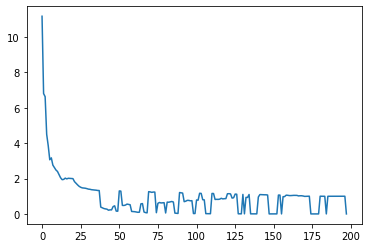

In [20]:
# Use eig_val plot to visualize how many components describe more percentage of variance in the dataset:
x= y2015
x=StandardScaler().fit_transform(x)####?????before applying pca need to convert all object columns to numeric with dummies?????
Xt = x.T                               ####??????????? also need filling columns before applying pca?????
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
# print scree plot
plt.plot(eig_val_cov)
plt.show()

#print(eig_val_cov)

In [21]:
# Apllying PCA for feature reduction:
X = y2015.drop(['loan_status_Current', 'loan_status_Default','loan_status_Fully Paid', 'loan_status_In Grace Period', 'loan_status_Late (16-30 days)', 'loan_status_Late (31-120 days)'], 1)
Y = y2015[['loan_status_Current', 'loan_status_Default','loan_status_Fully Paid', 'loan_status_In Grace Period', 'loan_status_Late (16-30 days)', 'loan_status_Late (31-120 days)']]
x = StandardScaler().fit_transform(x)
pca = PCA(0.90)
principalComponents = pca.fit_transform(x)

In [22]:
# Findout number of components explained 90% of variance in the dataset:
pca_number = pca.n_components_

In [23]:
# print the percentage of total variance in the dataset explained by each components:
print(
    'The percentage of total variance in the dataset explained by each, component from Sklearn PCA.\n',
    pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.05675862 0.03456031 0.03366312 0.0228581  0.01958447 0.01609176
 0.01554898 0.01401477 0.01333748 0.01261074 0.01218728 0.01125472
 0.01038415 0.01027448 0.01023215 0.01020126 0.01016295 0.01013185
 0.01006226 0.00991304 0.00983056 0.00927102 0.00879377 0.00833653
 0.00792491 0.00765344 0.00747966 0.00743422 0.00737708 0.00726587
 0.00711942 0.00707143 0.00695649 0.0069205  0.00685721 0.0068142
 0.00673395 0.00671293 0.00660245 0.00654763 0.00638553 0.00632595
 0.00627596 0.00627166 0.00618797 0.00614261 0.00604526 0.00598009
 0.00592914 0.00588721 0.00587909 0.00585464 0.005809   0.00578774
 0.00574707 0.00569079 0.00565601 0.00559907 0.00557715 0.00555632
 0.00552575 0.00549198 0.00549085 0.00547432 0.00542361 0.00540989
 0.00540637 0.00537968 0.00534738 0.00532963 0.00532593 0.00531549
 0.00529691 0.00526708 0.0052614  0.00521478 0.00521206 0.00516981
 0.0051452  0.00510074 0.00509093 0

In [24]:
# Convert PCA to dataframe:
principalDf = pd.DataFrame(data = principalComponents, columns = ['pca' + str(i) for i in range (1, pca_number+1)])


In [25]:
# Concat pca with target variable:
finaldf = pd.concat([principalDf, Y], axis = 1)
finaldf.head(5)

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,pca116,pca117,pca118,pca119,loan_status_Current,loan_status_Default,loan_status_Fully Paid,loan_status_In Grace Period,loan_status_Late (16-30 days),loan_status_Late (31-120 days)
0,6.044079,-4.246159,1.742596,6.815660,-4.397400,-1.836140,-4.275506,-3.365395,5.472831,2.739708,...,0.231419,-0.207052,-0.929218,-0.580002,1,0,0,0,0,0
1,-3.349010,-2.349625,-1.036469,2.516143,-0.430072,1.665220,-1.555065,1.607751,-0.482344,0.201285,...,0.424666,0.661328,-0.436924,-0.437555,1,0,0,0,0,0
2,2.491482,4.466535,-3.179003,2.090982,0.369160,-2.051150,-3.620343,0.973224,-0.534762,-0.086898,...,-0.232030,-0.563656,0.523195,0.178160,0,0,1,0,0,0
3,4.231183,-3.227620,-1.501697,1.108923,-1.158615,-2.607011,-1.880151,0.784001,1.147049,-1.454764,...,0.196796,0.459904,-0.551484,-0.253957,1,0,0,0,0,0
4,0.188524,3.538399,6.300961,-3.893785,1.226271,1.020369,-4.782680,1.388730,-1.008444,-1.088548,...,-1.545190,2.062297,2.630798,-0.694337,0,0,1,0,0,0


In [27]:
# Using random forest model with pca:
rfc = ensemble.RandomForestClassifier()
X = principalDf
Y = finaldf[['loan_status_Current', 'loan_status_Default','loan_status_Fully Paid', 'loan_status_In Grace Period', 'loan_status_Late (16-30 days)', 'loan_status_Late (31-120 days)']]

cross_val_score(rfc, X, Y, cv=10)

KeyboardInterrupt: 

As you can see here, with few featurs, the accuracy is around 0.96.

- Can you do it without using anything related to payment amount or outstanding principal? How do you know???????

In [ ]:
# Using random forest model with pca without using outstanding principals:
rfc = ensemble.RandomForestClassifier()
X = principalDf[:,]
Y = finaldf[['loan_status_Current', 'loan_status_Default','loan_status_Fully Paid', 'loan_status_In Grace Period', 'loan_status_Late (16-30 days)', 'loan_status_Late (31-120 days)']]

cross_val_score(rfc, X, Y, cv=10)

In [ ]:
# Apllying PCA for feature reduction in dataset without payment amount:

X = y2015.drop(['last_pymnt_d_Apr-2016',
       'last_pymnt_d_Aug-2015', 'last_pymnt_d_Aug-2016',
       'last_pymnt_d_Dec-2015', 'last_pymnt_d_Dec-2016',
       'last_pymnt_d_Feb-2015', 'last_pymnt_d_Feb-2016',
       'last_pymnt_d_Jan-2015', 'last_pymnt_d_Jan-2016',
       'last_pymnt_d_Jan-2017', 'last_pymnt_d_Jul-2015',
       'last_pymnt_d_Jul-2016', 'last_pymnt_d_Jun-2015',
       'last_pymnt_d_Jun-2016', 'last_pymnt_d_Mar-2015',
       'last_pymnt_d_Mar-2016', 'last_pymnt_d_May-2015',
       'last_pymnt_d_May-2016', 'last_pymnt_d_Nov-2015',
       'last_pymnt_d_Nov-2016', 'last_pymnt_d_Oct-2015',
       'last_pymnt_d_Oct-2016', 'last_pymnt_d_Sep-2015',
       'last_pymnt_d_Sep-2016', 'next_pymnt_d_Jan-2017',
       'next_pymnt_d_Jul-2016', 'next_pymnt_d_Mar-2017'], 1)

X = X[['total_rec_prncp', 'last_credit_pull_d_Oct-2016', 'last_credit_pull_d_Dec-2016','collection_recovery_fee','recoveries','last_credit_pull_d_Nov-2016', 'int_rate', 'last_credit_pull_d_Aug-2016','last_credit_pull_d_Jul-2016']]
Y = y2015[['loan_status_Current', 'loan_status_Default','loan_status_Fully Paid', 'loan_status_In Grace Period', 'loan_status_Late (16-30 days)', 'loan_status_Late (31-120 days)
x = StandardScaler().fit_transform(x)
pca = PCA(0.90)
principalComponents = pca.fit_transform(x)

In [ ]:
# Findout number of components explained 90% of variance in the dataset:
pca_number = pca.n_components_

In [ ]:
# print the percentage of total variance in the dataset explained by each components:
print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    pca.explained_variance_ratio_
)

In [ ]:
# Convert pca to dataframe:
principalDf = pd.DataFrame(data = principalComponents, columns = ['pca' + str(i) for i in range (1, pca_number+1)])


In [ ]:
# Concat pca with target variable:
finaldf = pd.concat([principalDf, Y], axis = 1)
finaldf.head(5)

In [ ]:
# Using random forest model with pca without payment amount:
rfc = ensemble.RandomForestClassifier()
X = principalDf
Y = finaldf[['loan_status_Current', 'loan_status_Default','loan_status_Fully Paid', 'loan_status_In Grace Period', 'loan_status_Late (16-30 days)', 'loan_status_Late (31-120 days)']]

cross_val_score(rfc, X, Y, cv=10)

As you can see here, with fewer featurs without payment amount , the accuracy is around 0.80.

????Im not sure my way is correct or not and without using anything related to payment amount or outstanding principal? ??????